In [175]:
#%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor, LinearRegression, Lasso
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_selector, make_column_transformer

# PST : Aile d'avion

**> Objectif : Prédire la portance maximale de l'aile d'avion en fonction de la géométrie de l'aile (épaisseur maximum, localisation et courbure)**   


Variables X :
- Name
- Thickness(%)
- x-Location_of_Max_Thk(%)
- Camber(%)

Targets y (Données JavaFoil obtenues à Re=3M, Mach 0, smooth)
- Cl_Max : coefficient de portance maximal
- Cl/Cd_Max : finesse, Lift-to-drag ratio

In [176]:
data = pd.read_csv('ailes_avion.csv', usecols=['Name','Thickness(%)', 'x-Location_of_Max_Thk(%)', 'Camber(%)', 'Cl_Max', 'Cl/Cd_Max', 'Cd@Cl=0.1', 'Cd@Cl=0.4', 'Cd@Cl=0.6'])
data.head(5)

,Name,Thickness(%),x-Location_of_Max_Thk(%),Camber(%),Cl_Max,Cl/Cd_Max,Cd@Cl=0.1,Cd@Cl=0.4,Cd@Cl=0.6
0,63A108 MOD C,7.7,30.1,0.6,1.02,64,0.011,0.013,0.013
1,A18,7.3,30.1,3.2,1.40,84,0.011,0.011,0.011
2,A18 (SMOOTHED),7.3,26.5,3.8,1.31,85,0.011,0.011,0.011
3,A6014-S,6.0,30.1,1.4,0.70,88,0.005,0.005,0.067
4,A6016-S,6.0,30.1,1.6,0.77,89,0.005,0.006,0.072


## 1. Data preliminary cleaning

In [177]:
data.shape

(6324, 9)

In [178]:
# Check columns types
data.dtypes

Name                         object
Thickness(%)                float64
x-Location_of_Max_Thk(%)    float64
Camber(%)                    object
Cl_Max                       object
Cl/Cd_Max                    object
Cd@Cl=0.1                    object
Cd@Cl=0.4                    object
Cd@Cl=0.6                    object
dtype: object

In [179]:
# Replace unknown values to be able to convert the object column to float
data.replace({'-': None}, inplace=True)

# Convert the necessary colums to float
convert_to_float = ['Camber(%)','Cl_Max', 'Cl/Cd_Max', 'Cd@Cl=0.1', 'Cd@Cl=0.4', 'Cd@Cl=0.6']
for i in convert_to_float:
    data[i] = data[i].astype(float)

In [180]:
# Number of unknown values per column
print(data.isna().sum())
# Comparison
ratio_na = (data.isna().sum().sum()/data.size)*100
print(f'The dataset contains {data.size} with only {data.isna().sum().sum()} missing values. (ratio {round(ratio_na,2)}%)')
# Delete the rows with missing value
data = data.dropna()

Name                         0
Thickness(%)                 0
x-Location_of_Max_Thk(%)     0
Camber(%)                   12
Cl_Max                       9
Cl/Cd_Max                    9
Cd@Cl=0.1                    9
Cd@Cl=0.4                    9
Cd@Cl=0.6                    9
dtype: int64
The dataset contains 56916 with only 57 missing values. (ratio 0.1%)


## 2. Exploratory Data Exploration

In [181]:
# The features of the dataset are the maximum thickness, its location and the camber.
# The primary target is the Cl_Max.
# The secondary targets are Cl/Cd_Max, Cd@Cl=0.1, Cd@Cl=0.4, Cd@Cl=0.6
# We will focus on the primary target and drop the secondary ones
df = data[['Thickness(%)', 'x-Location_of_Max_Thk(%)', 'Camber(%)','Cl_Max']]
# With the description, we can see that the numerical variables should be normalized during the pre-processing
df.describe()

,Thickness(%),x-Location_of_Max_Thk(%),Camber(%),Cl_Max
count,6303.000000,6303.000000,6303.000000,6303.000000
mean,13.441441,35.686324,2.662335,1.452210
std,4.146485,7.589685,1.730970,0.360184
min,2.000000,0.200000,-0.100000,0.310000
25%,10.000000,30.100000,1.400000,1.200000
50%,13.000000,35.800000,2.500000,1.430000
75%,16.900000,39.800000,3.700000,1.670000
max,38.900000,99.300000,14.700000,3.360000


c:\Users\Emeline\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


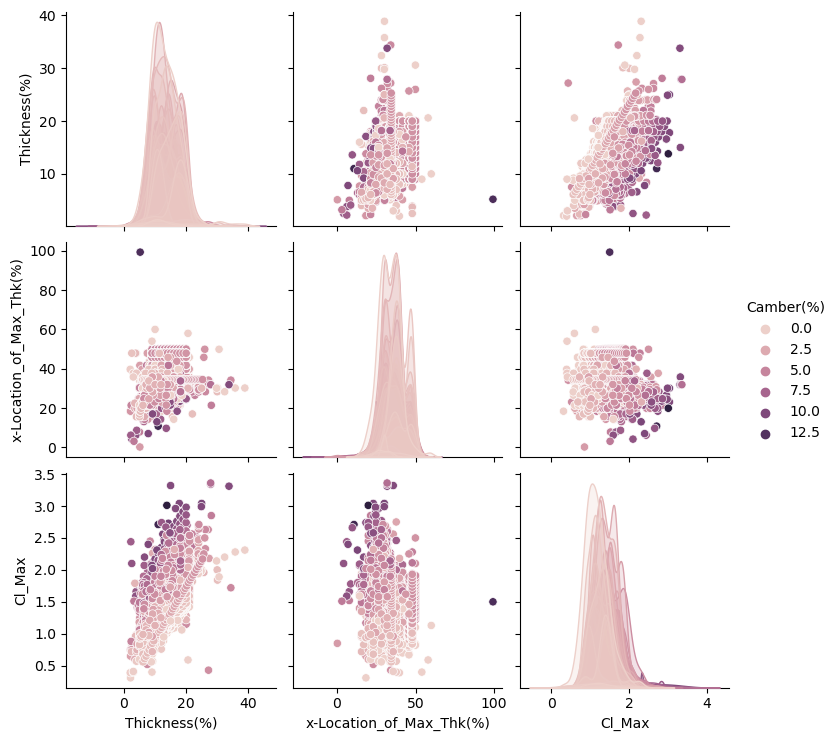

In [182]:
sns.pairplot(df, hue='Camber(%)')

Text(0, 0.5, 'Thickness')

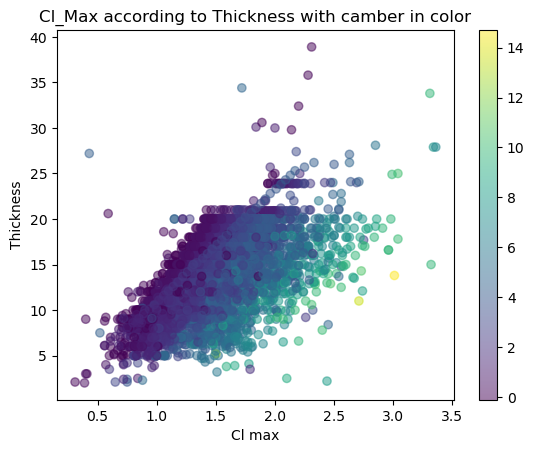

In [183]:
plt.scatter(df['Cl_Max'], df['Thickness(%)'], alpha=0.5, c=df['Camber(%)'])
plt.colorbar()
plt.title('Cl_Max according to Thickness with camber in color')
plt.xlabel('Cl max')
plt.ylabel('Thickness')

Text(0.5, 0, 'Cl_Max')

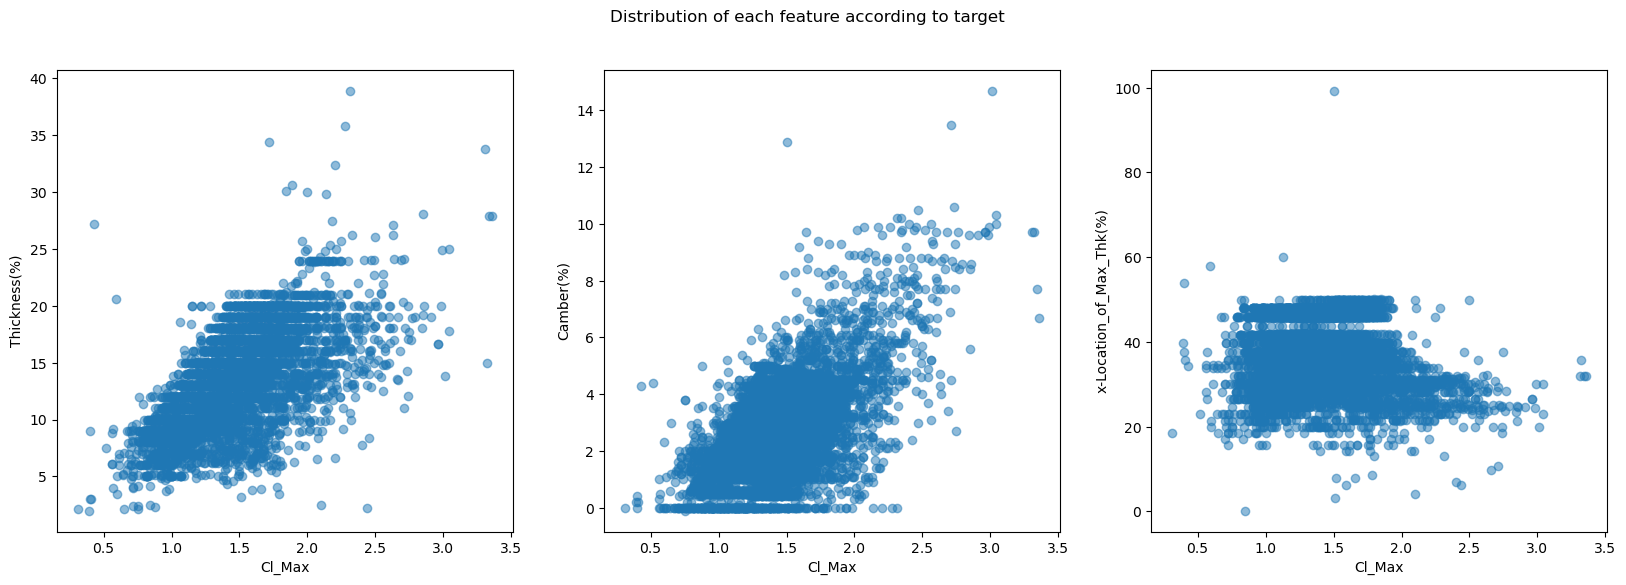

In [184]:
plt.figure(figsize=(20,6)).suptitle('Distribution of each feature according to target')
plt.subplot(1,3,1)
plt.scatter(df['Cl_Max'], df['Thickness(%)'], alpha=0.5)
plt.ylabel('Thickness(%)')
plt.xlabel('Cl_Max')
plt.subplot(1,3,2)
plt.scatter(df['Cl_Max'], df['Camber(%)'], alpha=0.5)
plt.ylabel('Camber(%)')
plt.xlabel('Cl_Max')
plt.subplot(1,3,3)
plt.scatter(df['Cl_Max'], df['x-Location_of_Max_Thk(%)'], alpha=0.5)
plt.ylabel('x-Location_of_Max_Thk(%)')
plt.xlabel('Cl_Max')

C:\Users\Emeline\AppData\Local\Temp\ipykernel_19416\3436286251.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Cl_Max'])


<Axes: xlabel='Cl_Max', ylabel='Density'>

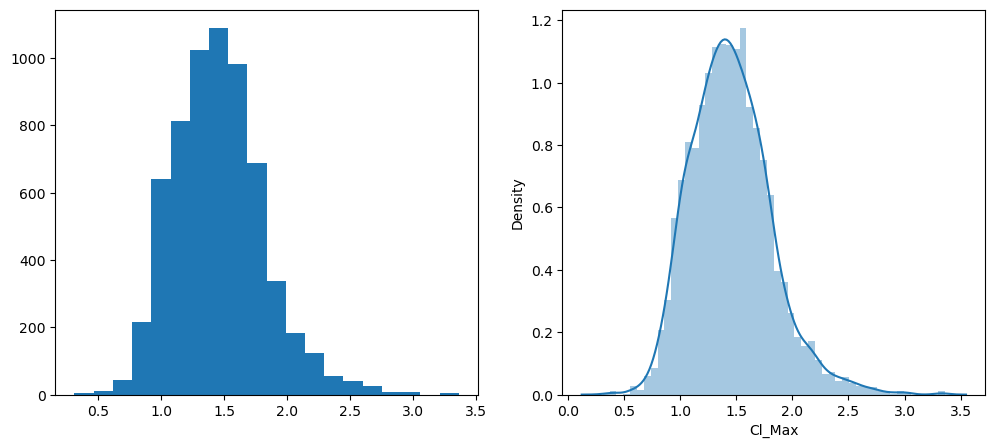

In [185]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(df['Cl_Max'], bins=20)
plt.subplot(122)
sns.distplot(df['Cl_Max'])

In [186]:
# Separate the features X from the target y and verify the shape
y = df[['Cl_Max']]
X = df.drop(columns=['Cl_Max'], axis=0)
print(y.shape)
print(X.shape)

(6303, 1)
(6303, 3)


<bound method Axes.legend of <Axes3D: >>

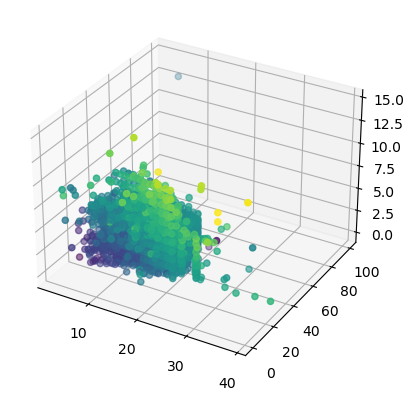

In [187]:
# 3d graph of our 3 features, the color represents Cl_max
ax = plt.axes(projection='3d')
ax.scatter(df['Thickness(%)'], df['x-Location_of_Max_Thk(%)'], df['Camber(%)'], c=y) 
# Add a color bar which maps values to colors.
ax.legend

In [188]:
corr_matrix = df[['Thickness(%)', 'x-Location_of_Max_Thk(%)', 'Camber(%)', 'Cl_Max']].corr()
corr_matrix

,Thickness(%),x-Location_of_Max_Thk(%),Camber(%),Cl_Max
Thickness(%),1.000000,0.269428,-0.026432,0.639146
x-Location_of_Max_Thk(%),0.269428,1.000000,-0.208821,-0.190036
Camber(%),-0.026432,-0.208821,1.000000,0.624988
Cl_Max,0.639146,-0.190036,0.624988,1.000000


<Axes: >

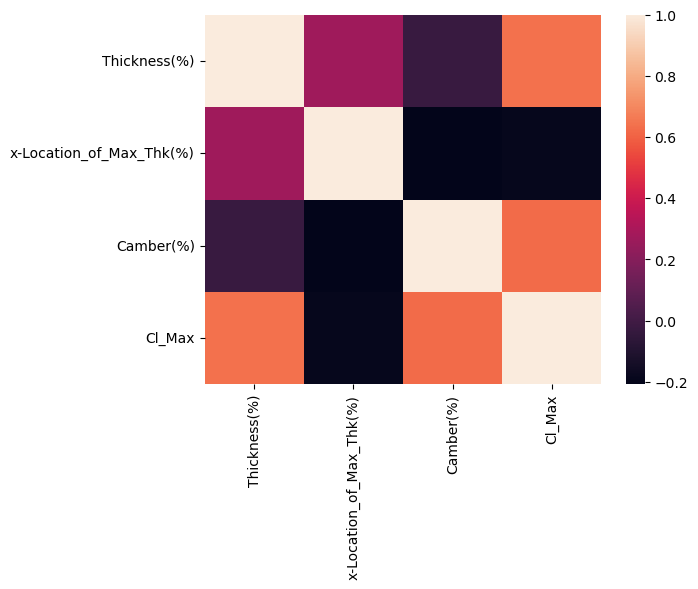

In [189]:
sns.heatmap(corr_matrix)

In [190]:
df.var()

Thickness(%)                17.193341
x-Location_of_Max_Thk(%)    57.603323
Camber(%)                    2.996258
Cl_Max                       0.129732
dtype: float64

<Axes: xlabel='Camber(%)', ylabel='Count'>

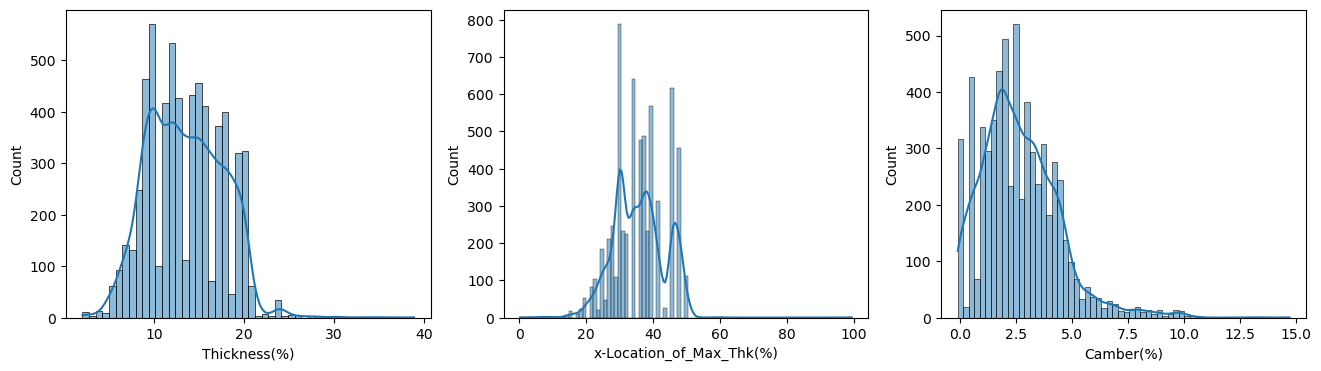

In [191]:
plt.figure(figsize=(16,4))
plt.subplot(131)
sns.histplot(df['Thickness(%)'], kde=True)
plt.subplot(132)
sns.histplot(df['x-Location_of_Max_Thk(%)'], kde=True)
plt.subplot(133)
sns.histplot(df['Camber(%)'], kde=True)

<Axes: xlabel='x-Location_of_Max_Thk(%)', ylabel='Camber(%)'>

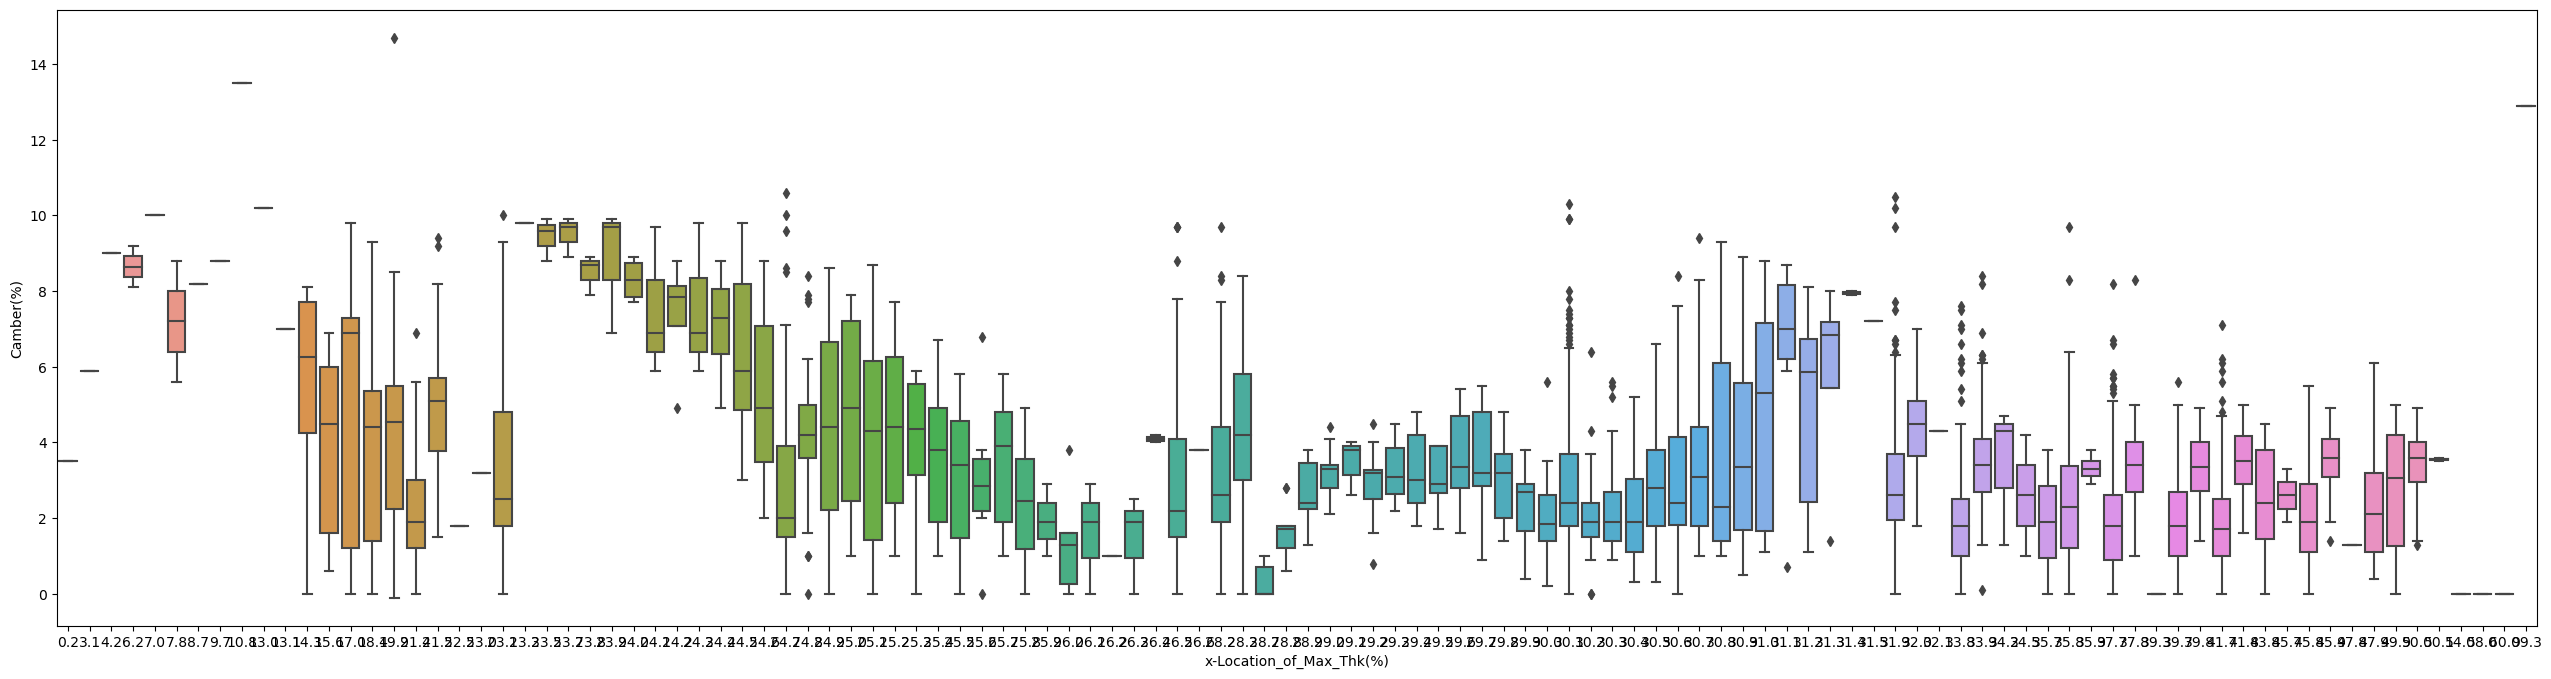

In [192]:
plt.figure(figsize=(32, 8))
sns.boxplot(x='x-Location_of_Max_Thk(%)', y='Camber(%)', data=X)

##  3. Data Pre-processing

In [193]:
# Splitting the dataset into training (80%) and testing (20%)
# Random_state is used to use the same randomization seed every time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Outlier Handling

In [194]:
# Method 1 for removing outliers
# # Calculating the IQR for a DataFrame
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
low_threshold = Q1-1.5*IQR
high_treshold = Q3+1.5*IQR
mask1 = (X_train['Thickness(%)'] < low_threshold[0]) | (X_train['Thickness(%)'] > high_treshold[0])
mask2 = (X_train['x-Location_of_Max_Thk(%)'] < low_threshold[0]) | (X_train['x-Location_of_Max_Thk(%)'] > high_treshold[0])
mask3 = (X_train['Camber(%)'] < low_threshold[0]) | (X_train['Camber(%)'] > high_treshold[0])
#plt.scatter(X_train['Thickness(%)'], X_train['Camber(%)'], c=mask1)

In [195]:
from sklearn.ensemble import IsolationForest

# Detecting outliers with a random forest

mode_if = IsolationForest(n_estimators=100, contamination=0.01)
mode_if.fit(X_train)
predictions_outliers = mode_if.predict(X_train)
print(predictions_outliers[:20])
print("Number of outliers detected: {}".format(predictions_outliers[predictions_outliers < 0].sum()))
print("Number of normal samples detected: {}".format(predictions_outliers[predictions_outliers > 0].sum()))
outliers = X_train[predictions_outliers < 0]

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Number of outliers detected: -51
Number of normal samples detected: 4991


Text(0.5, 0, 'Cl_Max')

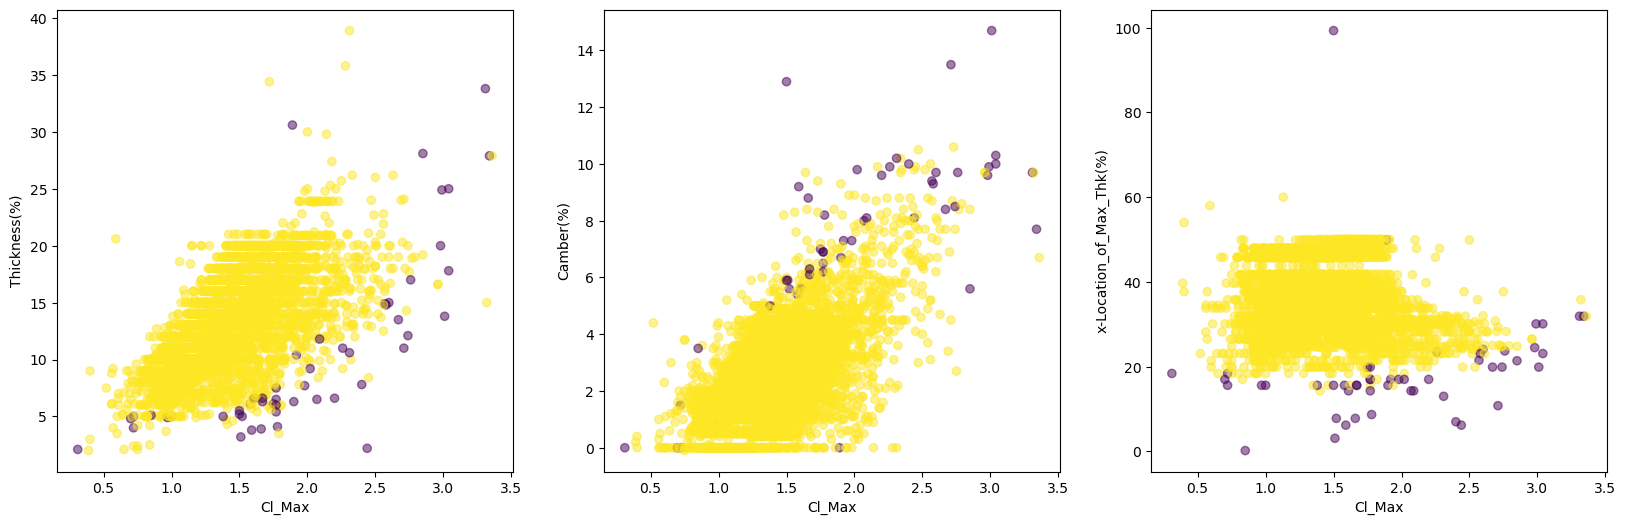

In [196]:
# Visualizing the outliers detected by the random forest

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.scatter(y_train, X_train['Thickness(%)'], alpha=0.5, c=predictions_outliers)
plt.ylabel('Thickness(%)')
plt.xlabel('Cl_Max')
plt.subplot(1,3,2)
plt.scatter(y_train, X_train['Camber(%)'], alpha=0.5, c=predictions_outliers)
plt.ylabel('Camber(%)')
plt.xlabel('Cl_Max')
plt.subplot(1,3,3)
plt.scatter(y_train, X_train['x-Location_of_Max_Thk(%)'], alpha=0.5,  c=predictions_outliers)
plt.ylabel('x-Location_of_Max_Thk(%)')
plt.xlabel('Cl_Max')

In [197]:
# Since the outliers detection seems coherent, we can drop them from the training set
X_train.drop(outliers.index, axis=0, inplace=True)
y_train.drop(outliers.index, axis=0, inplace=True)
print(f"Il reste {X_train.shape} dans le train set des features \n")
print(f"Il reste {y_train.shape} dans le train set des targets \n")

Il reste (4991, 3) dans le train set des features 

Il reste (4991, 1) dans le train set des targets 



In [198]:
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(f"Shape des training targets {y_train.shape} \n")
print(f"Shape des testing targets {y_test.shape} \n")

Shape des training targets (4991, 1) 

Shape des testing targets (1261, 1) 



In [199]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Data Modelling 

Linear Regression

In [200]:
model_lg = LinearRegression()
model_lg.fit(X_train, y_train)
print(model_lg.score(X_test, y_test))
print("Coefficients: \n", model_lg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, model_lg.predict(X_test)))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, model_lg.predict(X_test)))


0.8870959803152345
Coefficients: 
 [[ 0.06320147 -0.01262998  0.12289347]]
Mean squared error: 0.01
Coefficient of determination: 0.89


Linear Regression with scaled data

In [201]:
model_lg_scaled = LinearRegression()
model_lg_scaled.fit(X_train_scaled, y_train)
print(model_lg_scaled.score(X_test_scaled, y_test))
print("Coefficients: \n", model_lg_scaled.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, model_lg_scaled.predict(X_test_scaled)))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, model_lg_scaled.predict(X_test_scaled)))


0.8870959803152345
Coefficients: 
 [[ 0.25774796 -0.0928844   0.20236505]]
Mean squared error: 0.01
Coefficient of determination: 0.89


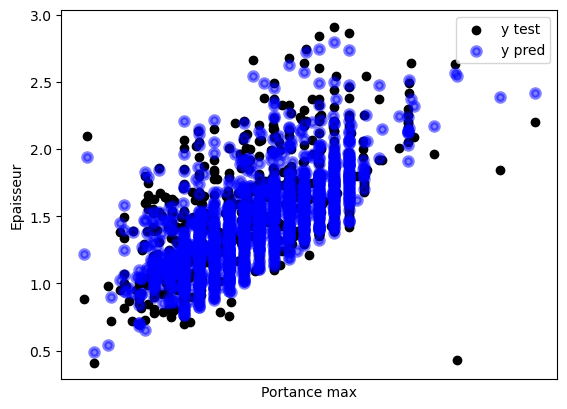

In [202]:
# Plot outputs
plt.scatter(X_test.iloc[:,0], y_test, color="black", label='y test')
plt.scatter(X_test.iloc[:,0], model_lg.predict(X_test), color="blue", linewidth=3, alpha=0.5, label='y pred')
plt.legend()
plt.xticks(())
plt.xlabel('Portance max')
plt.ylabel('Epaisseur')
plt.show()

Trying pipeline and GridSearchCV

In [215]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [1,2,3,4],
}
regr = RandomForestRegressor(random_state=0)

clf = GridSearchCV(regr, parameters)
clf.fit(X_train, y_train.ravel())
print(clf.score(X_test, y_test.ravel()))
print(clf.best_estimator_)


0.8411130529950119
RandomForestRegressor(max_depth=4, random_state=0)


In [217]:
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
    }
regr = RandomForestRegressor(random_state=0)

clf = GridSearchCV(regr, parameters)
clf.fit(X_train_scaled, y_train.ravel())
print(clf.score(X_test_scaled, y_test.ravel()))
print(clf.best_estimator_)

KeyboardInterrupt: 

In [203]:
pipe = make_pipeline(StandardScaler(),
                      SGDRegressor(), 
                      LinearRegression())

numerical_pipeline = make_pipeline(StandardScaler())
numerical_features = ['Thickness(%)', 'x-Location_of_Max_Thk(%)', 'Camber(%)']

preprocessor = make_column_transformer((numerical_pipeline, numerical_features))

params = {
    'sgdregressor__alpha': 10.0 ** -np.arange(1, 7),
    'sgdregressor__loss': ['squared_error', 'huber', 'squared_epsilon_insensitive', 'epsilon_insensitive'],
    'sgdregressor__penalty': ['l2', 'l1', 'elasticnet'],
    'sgdregressor__learning_rate': ['constant', 'optimal', 'invscaling'],
}

pipe = make_pipeline(preprocessor, SGDRegressor())

pipe.fit(X_train, y_train.ravel())
pipe.score(X_test, y_test.ravel())

grid = GridSearchCV(pipe, param_grid=params, cv=4, error_score='raise')

grid.fit(X_train, y_train.ravel())
print(grid.score(X_test, y_test.ravel()))
print(grid.best_estimator_)

0.886688644211379
Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Thickness(%)',
                                                   'x-Location_of_Max_Thk(%)',
                                                   'Camber(%)'])])),
                ('sgdregressor',
                 SGDRegressor(alpha=1e-06, penalty='elasticnet'))])


In [204]:
# array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06])
# 0.1

[ 399  798 1197 1596 1996 2395 2794 3193 3592 3992]


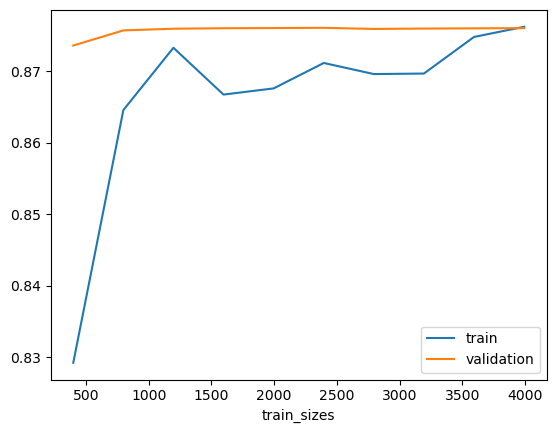

In [205]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(model_lg, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [206]:
train_score = 1-np.mean(train_score,axis=1)#converting the accuracy score to misclassification rate
val_score = 1-np.mean(val_score,axis=1)#converting the accuracy score to misclassification rate
lc = pd.DataFrame({"Training_size":N,"Training_loss":train_score,"Validation_loss":val_score}).melt(id_vars="Training_size")

Text(0, 0.5, 'Misclassification Rate/Loss')

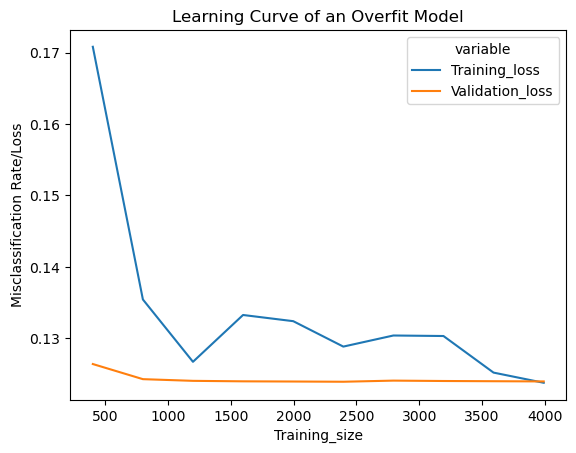

In [207]:
sns.lineplot(data=lc,x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of an Overfit Model")
plt.ylabel("Misclassification Rate/Loss")

c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

[ 399  798 1197 1596 1996 2395 2794 3193 3592 3992]


c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Emeline\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

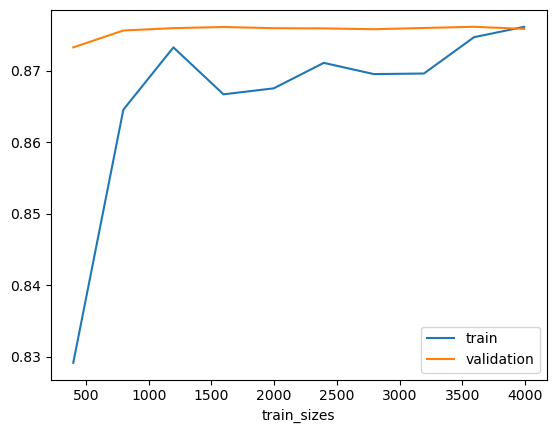

In [211]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(grid.best_estimator_, X_train, y_train,
                                           train_sizes=np.linspace(0.1, 1, 10), cv=5)

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [212]:
train_score = 1-np.mean(train_score,axis=1)#converting the accuracy score to misclassification rate
val_score = 1-np.mean(val_score,axis=1)#converting the accuracy score to misclassification rate
lc = pd.DataFrame({"Training_size":N,"Training_loss":train_score,"Validation_loss":val_score}).melt(id_vars="Training_size")

Text(0, 0.5, 'Misclassification Rate/Loss')

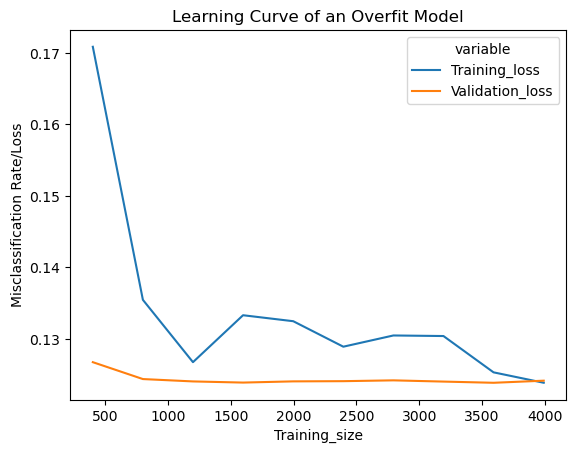

In [213]:
sns.lineplot(data=lc,x="Training_size",y="value",hue="variable")
plt.title("Learning Curve of an Overfit Model")
plt.ylabel("Misclassification Rate/Loss")